The idea of the project is to increase the classification accuracy of T1w from the image quality metrics(output from MRIQC Pipeline) and motion parameters from task runs of ABIDE dataset.

I started playing with linear regression, PCA, knn. Optimized Random forest and SVC to get the best accuracy as 56%.


In [180]:
import pandas as pd
import numpy as np
import matplotlib as mat
import seaborn as sns
import scipy, os, glob, re 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# use seaborn for plot defaults
# this can be safely commented out
import seaborn; seaborn.set()


In [181]:
from sklearn.linear_model import LinearRegression



In [182]:
data = pd.read_csv('./data.csv')
# 

mask_vec = ~np.isnan(data['func_dvars'])
clean_df = data[mask_vec]
mask_vec = ~np.isnan(data['func_mean_fd'])
data = clean_df[mask_vec]


/Users/suyashdb/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [183]:
X = data.iloc[:,2:-4]
X.shape
y = data.iloc[:,-3:-1] 
y_new = data.iloc[:,-1]
# print(y_new.value_counts(), y.iloc[:,0].value_counts())


Converted rating for rows where both raters have rated into one column by random sampling

In [184]:
y = data.iloc[:,-3:-1] 
# y_new = data.iloc[:,-1]
import random
for index, row in y.iterrows():
    if row.isnull().any():
#         print(row.sum())
        y_new.iloc[index,] = row.sum()
    else:
        y_new.iloc[index,] = random.choice(row)

/Users/suyashdb/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


IndexError: single positional indexer is out-of-bounds

In [98]:
y_new.shape, X.shape
# print(X_new.dtypes.value_counts())
# y_new.isnull()
# np.isnan(y_new.values).sum()

((1098,), (1098, 70))

In [179]:
y_new.value_counts()

 1    419
 0    348
-1    331
Name: rater_3, dtype: int64

### K Nearest neighbour (without optimization)

In [99]:
# from sklearn.linear_model import 

from sklearn.neighbors import KNeighborsClassifier
X_new = X.dropna()
clf = KNeighborsClassifier()
clf.fit(X_new.values, y_new)
# print(X_new.dtypes.value_counts())
# y_new.isnull()
# np.isnan(y_new.values).sum()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y_new)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))

[[47 25 16]
 [30 32 15]
 [27 38 45]]


### SGD (without optimization)


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_new = X_new.dropna()
clf = SGDClassifier(loss= 'perceptron')
clf.fit(X_new.values, y_new)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y_new)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
c = confusion_matrix(ytest, ypred, labels=[-1,0,1])
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))

[[ 73   0   1]
 [ 99   0   0]
 [102   0   0]]


In [13]:
from pandas_ml import ConfusionMatrix
C = ConfusionMatrix(ytest, ypred)
C

Predicted  -1.0  0.0  1.0  __all__
Actual                            
-1.0         28    0    0       28
0.0          17    0    0       17
1.0          18    0    0       18
__all__      63    0    0       63

In [14]:
plotdata= pd.concat([X_new,y_new], axis = 1)

In [174]:
# sns.regplot(plotdata['func_mean_fd'], plotdata['func_dvars'], fit_reg=False,color='rater_3'  )

In [ ]:
# plt.scatter(plotdata['func_mean_fd'], plotdata['func_dvars'], hu)

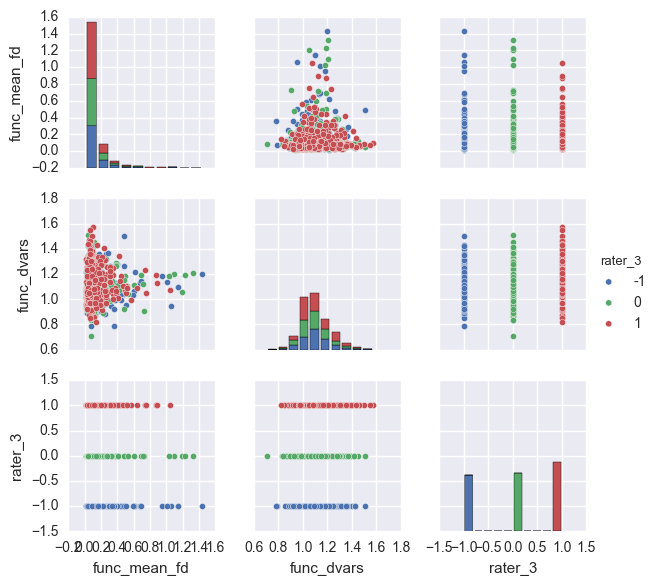

In [15]:
sns.pairplot(plotdata.iloc[:,-3:],size=2,hue='rater_3')

Tried PCA to reduce the feature matrix to check if reduced feature matrix would help SVC and KNN classification

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (1098, 70)
transformed shape: (1098, 20)


In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
df2 = pd.DataFrame(data=X_pca[:,:], index=range(0,1098), columns=range(0,20))
df2.shape

(1098, 20)

In [18]:
clf = SGDClassifier(loss= 'perceptron')
clf.fit(df2.values, y_new)
Xtrain, Xtest, ytrain, ytest = train_test_split(df2, y_new)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
c = confusion_matrix(ytest, ypred, labels=[-1,0,1])
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))

[[74  2  2]
 [71 12  7]
 [70  9 28]]


In [125]:
df2.shape

(1098, 20)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

Settting up Logistic regression pipeline 


In [185]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
pipe = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring= 'f1',loss= 'hinge')) #StandardScalar is feature slection and logistic regresiion is the ML algo
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)

TypeError: __init__() got an unexpected keyword argument 'loss'

In [46]:
c = confusion_matrix(ytest, ypred, labels=[-1,0,1])
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))
print(c)

             precision    recall  f1-score   support

         -1       0.57      0.50      0.53        78
          0       0.45      0.27      0.34        90
          1       0.51      0.73      0.60       107

avg / total       0.51      0.51      0.49       275

[[39  9 30]
 [21 24 45]
 [ 9 20 78]]


#### Linear SVC pipeline

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
pipe = make_pipeline(StandardScaler(), LinearSVC(loss= 'hinge',)) #StandardScalar is feature slection and logistic regresiion is the ML algo
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)

Accuracy of classification is 0.47 +- 0.03


In [51]:
c = confusion_matrix(ytest, ypred, labels=[-1,0,1])
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))
print(c)

             precision    recall  f1-score   support

         -1       0.43      0.65      0.52        78
          0       0.20      0.03      0.06        90
          1       0.50      0.66      0.57       107

avg / total       0.38      0.45      0.39       275

[[51  5 22]
 [38  3 49]
 [29  7 71]]


#### Grid Search for Linear SVC


In [64]:
LVC_pipe

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [68]:
y.shape

(1098, 2)

In [69]:
from sklearn.model_selection import GridSearchCV

parameters = {'linearsvc__C':[1,0.9]}
LVC_pipe = make_pipeline(StandardScaler(), LinearSVC(loss= 'hinge'))
LVC_grid = GridSearchCV(LVC_pipe,parameters)
LVC_grid.fit(X, y_new)
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)
print(classification_report(ytest, ypred))

Accuracy of classification is 0.47 +- 0.03
             precision    recall  f1-score   support

         -1       0.43      0.67      0.53        78
          0       0.23      0.03      0.06        90
          1       0.49      0.65      0.56       107

avg / total       0.39      0.45      0.39       275



In [54]:
GridSearchCV(LVC_pipe,parameters)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 0.6, 0.7, 0.9, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

### Random Forest

In [78]:
RF_pipe

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [106]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
parameters = {'randomforestclassifier__max_depth':[1,0.9]}
RF_pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
RF_grid = GridSearchCV(RF_pipe,parameters)
RF_grid.fit(X, y_new)
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)
print(classification_report(ytest, ypred))

Accuracy of classification is 0.56 +- 0.03
             precision    recall  f1-score   support

         -1       0.68      0.55      0.60        88
          0       0.37      0.30      0.33        77
          1       0.54      0.69      0.61       110

avg / total       0.53      0.53      0.53       275



In [108]:
c = confusion_matrix(ytest, ypred, labels=[-1,0,1])
c

array([[48, 12, 28],
       [17, 23, 37],
       [ 6, 28, 76]])

In [137]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# ANOVA
selector = SelectKBest(f_classif, 40)
selector.fit(Xtrain, ytrain)
print(selector.scores_)
print(selector.transform(Xtrain).shape, ytrain.shape)
Xtrain_reduced = selector.transform(Xtrain)

[ 10.8644194   32.89071998  32.51956643   2.81772833  14.31993194
  19.6079516   28.54484745  24.70459712  10.48046228   4.57476252
  10.46217322  26.83504659  12.53116629   1.07955592   2.77482259
  13.38018077  13.91580702   7.79199503  24.97471949  27.46939397
  48.85389985   6.03972578   1.79770495  16.49575037  35.29633656
   3.17705693   4.89165261   4.13869303   3.89998903  18.65062081
  37.58051193  44.0332605    0.08561305  38.8057792    1.99874561
   2.60899871  39.51778551  14.70414333   3.41003162  27.54476217
   1.7922797    3.36445489   7.77829945   2.54161478  17.69437573
   4.50968008   9.32296365   9.5528211    6.18712635   6.14057542
   1.94076979   2.00847985  23.35149522   1.12569271   2.85066525
   5.44293385   4.47794998  31.40654977  15.90713158  12.38305085
  28.91765204  12.59219016  40.60882683  35.22450878  11.68630987
   1.81046255   7.07208631  60.52889788   2.90231884   1.64007427]
(823, 40) (823,)


In [138]:
Xtrain.columns[selector.get_support()]

Index(['cjv', 'cnr', 'efc', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
       'icvs_csf', 'icvs_wm', 'inu_med', 'inu_range', 'rpve_csf', 'rpve_gm',
       'rpve_wm', 'size_x', 'size_y', 'size_z', 'snr_total', 'snr_wm',
       'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_mad', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_stdv', 'summary_csf_mean',
       'summary_csf_n', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_n',
       'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median',
       'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv',
       'tpm_overlap_csf', 'wm2max'],
      dtype='object')

In [124]:
Xtrain_reduced.shape
Xtrain, Xtest, ytrain, ytest = train_test_split(df2, y_new)

(823, 20)

In [151]:
# on reduced feature set
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# parameters = {'randomforestclassifier__max_depth':range(1,50),'randomforestclassifier'}
parameters = {'randomforestclassifier__n_estimators':range(10,100)}
RF_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(oob_score=True,max_features='sqrt',bootstrap=True))
RF_grid = GridSearchCV(RF_pipe,parameters)
RF_grid.fit(Xtrain, ytrain)
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)
print(classification_report(ytest, ypred))
print(confusion_matrix(ytest, ypred, labels=[-1,0,1]))


/Users/suyashdb/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/suyashdb/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/suyashdb/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/suyashdb/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estim

Accuracy of classification is 0.56 +- 0.03
             precision    recall  f1-score   support

         -1       0.68      0.55      0.60        88
          0       0.37      0.31      0.34        77
          1       0.55      0.69      0.61       110

avg / total       0.54      0.54      0.53       275

[[48 13 27]
 [17 24 36]
 [ 6 28 76]]


#### SVC Parameter Optimization

In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# parameters = {'randomforestclassifier__max_depth':range(1,50),'randomforestclassifier'}
parameters = {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'],'svc__gamma': [0.001, 0.0001]}
SVC_pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
SVC_grid = GridSearchCV(SVC_pipe,parameters)
SVC_grid.fit(Xtrain, ytrain)
scores = cross_val_score(pipe, Xtrain, ytrain, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
pipe.fit(Xtrain, ytrain)
ypred= pipe.predict(Xtest)
print(classification_report(ytest, ypred))
print(confusion_matrix(ytest, ypred, labels=[-1,0,1]))


Accuracy of classification is 0.55 +- 0.03
             precision    recall  f1-score   support

         -1       0.67      0.56      0.61        88
          0       0.36      0.31      0.34        77
          1       0.55      0.68      0.61       110

avg / total       0.54      0.54      0.53       275

[[49 14 25]
 [17 24 36]
 [ 7 28 75]]


In [169]:
##tried model on train dataset which itself not working 
ypred= pipe.predict(Xtrain)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))
print(classification_report(ytrain, ypred))

Accuracy of classification is 0.55 +- 0.03
             precision    recall  f1-score   support

         -1       0.68      0.65      0.67       249
          0       0.57      0.40      0.47       268
          1       0.59      0.77      0.67       306

avg / total       0.61      0.61      0.60       823



In [154]:
SVC_pipe

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

#### Inputs from Aerial

1) First split the data as per different labels, and plot the distribution of each feature to see if each feature has a statistical property to describe the data. Once you explore that try Modeling. 

2) for the current models, try how model is behaving on the training dataset first. See if that overfits. That will give you intuition if model is worth.
